# TIme depeNdent ConduiT flow neUral netwoRk Emulator (TINCTURE)

A collaboration between Ying Qi Wong, PhD and Ben Mullet

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import tqdm

import domegoveqn
import constitutive


## Gather training data

(This section is adapted from YQ's notebook "RunModel")

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

path_to_domeconduit_code = "/home/bmullet/Research/software/domeconduit/Code/"

eng.addpath (eng.genpath(path_to_domeconduit_code), nargout= 0 )

### Run time-dependent conduit model by calling matlab functions 

First start matlab and add paths for model functions


#### Run the full time-dependent model using default parameters

In [3]:
def n_by_1(array):
  """Transform array to Nx1"""
  array = np.array(array)
  
  assert len(array.shape) <= 2, "Array dim should be <= 2"
  
  if len(array.shape) < 2:
    array = array[:,np.newaxis]
  
  L, W = array.shape
  if L < W:
    array = array.T
    
  return array



In [4]:
n = n_by_1(np.array([1,2,3]))
m = np.array([1,2,3])

In [23]:
class conduit_model_data_handler():
  
  conduit_var_names = ["p", "v", "phi_g", "mw"]
  
  def __init__(self,
               normalize=True,
               use_default_params=True,
              ):
    
    # options
    self.normalize = normalize    # Should we rescale data to (0,1)
    
    if use_default_params:
      # Get data
      o    = eng.tdcFV('setdef', nargout=1)
      opts = eng.tdcFV('ss_init',o,nargout=1)
      opts['Nz'] = 401.

      # run steady-state model
      ss, opts, ssflag = eng.tdcFV('run_ssc_opts', opts, nargout=3)

      # load time-dependent options
      m, y0, z = eng.tdcFV('td_init', ss['m'], ss, 0, 0, nargout=3)

      # run time-dependent model
      td, m, flag = eng.tdcFV('run_tdc', y0, z, m, nargout=3)
    else:
      # Do custom set of model parameters
      raise NotImplementedError
    
    # Set model parameters
    self.model_params = constitutive.reformat_params(ss['m'])

    # Sets self.z, self.t, and self.conduit_vars
    self.set_results_vars(td, m)
    
    # Set dimensions
    self.nz = max(self.z.shape)
    self.nt = max(self.t.shape)
    self.default_shape = (self.nz, self.nt)
    
    # Sets self.in_array, self.out_array
    self.set_nn_inputs_and_outputs()
    

  def set_results_vars(self, td, m):

    # Extract solution
    tdvarsVec = eng.extract_y(td, m, nargout=1)

    # Get time and conduit depth variables
    self.z = n_by_1(td['z'])
    self.t = n_by_1(td['x'])

    # Subsample (for now)
    t_idx = (np.linspace(0,max(self.t.shape)- 1,3)).astype(int)
    
    self.t = self.t[t_idx]
    
    import pdb; pdb.set_trace()
    # Get conduit variables
    self.conduit_vars = {key: np.array(val)[:, t_idx] for key, val in tdvarsVec.items()
                    if key in conduit_model_data_handler.conduit_var_names}  
    
    # Get boundary conditions
    bottom_idx = np.argmin(self.z)
    top_idx = np.argmax(self.z)
    
    # Conduit bottom boundary conditions are set on p, phi_g, and m_h (not v)
    bottom_bcs = ["p", "phi_g", "mw"]
    
    # Conduit top boundary conditions are only set on p
    top_bcs = ["p"]

    # Creates a mask for those entries which are also boundary conditions
    self.conduit_bcs = {}
    for var in conduit_model_data_handler.conduit_var_names:
      self.conduit_bcs[var] = np.zeros(self.conduit_vars[var].shape)
      if var in bottom_bcs:
        self.conduit_bcs[var][bottom_idx, :] = 1
      if var in top_bcs:
        self.conduit_bcs[var][top_idx, :] = 1
        
    
    
  def set_nn_inputs_and_outputs(self):
    # We need to reshape the inputs and outputs to fit what tensorflow expects.
    # Inputs should be size (Nx2) where 2 is because we have two input variables t and z
    # Outputs should be size (Nx4) where 4 is ebcause we have four outputs variables,
    # p, v, phi_g and mw

    nt = self.t.shape[0]
    nz = self.z.shape[0]

    nouts = len(self.conduit_vars)
    nins = 2 # one for t and one for z

    out_array = np.empty((nt*nz, nouts))
    bc_mask = np.empty((nt*nz, nouts))
    
    for i, var_name in enumerate(conduit_model_data_handler.conduit_var_names):
      bc_mask[:,i] = self.conduit_bcs[var_name].flatten()
      
      var_1d = self.conduit_vars[var_name].flatten()
      if self.normalize:
        valmax = np.amax(var_1d)
        valmin = np.amin(var_1d)
        out_array[:,i] = (var_1d - valmin)/(valmax - valmin) # normalize
      else:
        out_array[:,i] = var_1d

    in_array = np.empty(((nt*nz), nins))
    T, Z = np.meshgrid(self.t, self.z)
    
    if self.normalize:
      in_array[:,0] = T.flatten()/np.amax(np.abs(T))
      in_array[:,1] = Z.flatten()/np.amax(np.abs(Z))
    else:
      in_array[:,0] = T.flatten()
      in_array[:,1] = Z.flatten()

    self.in_array = in_array
    self.out_array = out_array
    self.bc_mask = bc_mask
    
  def plot(self, num_profiles=3, in_array=None, out_array=None, out_array2=None):
    """Plot some output, given in_array and out_array"""
    if in_array is None:
      in_array = self.in_array
    if out_array is None:
      out_array = self.out_array
      
    if out_array2 is not None:
      assert out_array2.shape == self.out_array.shape, "The shape of out_array2 is incorrect"
      
    assert in_array.shape == self.in_array.shape, "The shape of in_array is incorrect"
    assert out_array.shape == self.out_array.shape, "The shape of out_array is incorrect"
    
    plt.figure(figsize=(15, 3))
    nsub = len(conduit_model_data_handler.conduit_var_names)
    
    # Get indices for plotting
    plot_t_idx = (np.linspace(0,self.nt - 1,num_profiles)).astype(int)
    
    for i, var_name in enumerate(conduit_model_data_handler.conduit_var_names):
      arrayi = out_array[:,i].reshape((self.default_shape))
    
      plt.subplot(1, nsub, i+1)
      lines = plt.plot(arrayi[:,plot_t_idx], self.z)
      for j, line in enumerate(lines):
        years = f"{seconds_to_years(self.t[plot_t_idx][j,0]):0.2f}"
        line.set_label(years)
      if out_array2 is not None:
        arrayi2 = out_array2[:,i].reshape((self.default_shape))
        plt.plot(arrayi2[:,plot_t_idx], self.z, "--r")
        
      plt.xlabel(var_name)
      plt.ylabel("z")
      plt.legend()
  
    plt.tight_layout()
    plt.show()

def seconds_to_years(seconds):
  return seconds/60/60/24/365
    

In [24]:
# Load data
c = conduit_model_data_handler()
print(c.model_params.keys())

> <ipython-input-23-1ca8af4bd57a>(62)set_results_vars()
     60     import pdb; pdb.set_trace()
     61     # Get conduit variables
---> 62     self.conduit_vars = {key: np.array(val)[:, t_idx] for key, val in tdvarsVec.items()
     63                     if key in conduit_model_data_handler.conduit_var_names}  
     64 



ipdb>  print(tdvarsVec.keys())


dict_keys(['x', 'y', 'z', 'yp', 'xe', 'ye', 'ie', 'tyr', 'p', 'v', 'phi_g', 'mw'])


ipdb>  exit


BdbQuit: 

In [7]:
# Check to make sure we have the right boundary conditions
a = c.out_array*c.bc_mask
ind = a > 0

print(a) # should be pressure, phi_g, and mw only
print(sum(c.bc_mask)) # should have twice as many for p as for phi_g and mw (b/c p is top and bottom bc)

[[1.         0.         0.         0.        ]
 [0.98585104 0.         0.00676944 0.02413536]
 [0.95044581 0.         0.02458012 0.08145108]
 ...
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
[6. 0. 3. 3.]


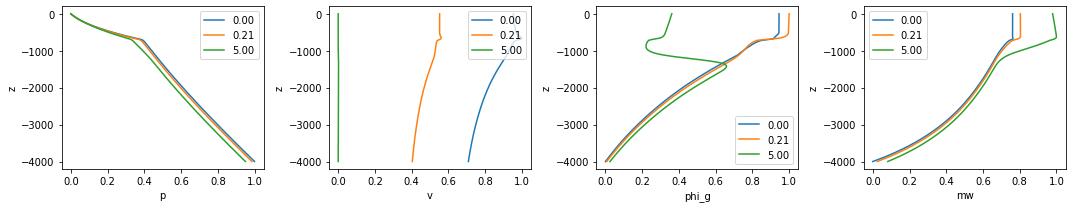

In [11]:
# Plot example model realizations
c.plot()  

### Set up model

In [12]:
# Neural network model

class PDENeuralNet(tf.keras.Model):
  def __init__(self, n_inputs, n_outputs):
    super().__init__()
    
    self.n_inputs = n_inputs
    self.n_outputs = n_outputs
  
    self.nn_model = tf.keras.Sequential([
      Dense(100, activation=tf.nn.elu),
      Dense(100, activation=tf.nn.elu),
      Dense(40, activation=tf.nn.elu),
      Dense(30, activation=tf.nn.elu),
      Dense(10, activation=tf.nn.elu),
      Dense(self.n_outputs, activation=None), # No activation last layer matches PINN paper
    ])

    self(tf.zeros([1, self.n_inputs]))  # dummy call to build the model

  @tf.function
  def call(self, x):
    z = self.nn_model(x)
    return z

In [13]:
# Neural network parameters
N_INPUTS = 2
N_OUTPUTS = 4


In [18]:
def get_optimzer(type="Adam", lr=2e-3):
  """Sets up NN model optimizer"""
  if type=="Adam":
    trainer = tf.keras.optimizers.Adam(learning_rate = lr)
  else:
    trainer = tf.keras.optimizers.SGD(learning_rate = lr)
  return trainer

trainer = get_optimzer()

def get_conduit_vals(p, u, A):
  
  raise NotImplementedError

  return 


def get_physics(y, v, dvdy, modelparams):
  """Get the the governing equations.
  Inputs:
    y: (N x 2) tensor of (z,t) pairs
    v: (N x 4) tensor of (p,v,phi_g,m_g) primary conduit variables
    dvdy: 4 element list of gradients
    modelparams: dictionary of model parameters
  Returns:
    F: (N x M) tensor for the M governing equations for each of the N samples.
       Each entry should equal zero if the physics are satisfied.
  
  See the note at the bottom of this notebook for an explanation.
  """
 
  z, t = split_tensor(y)
  conduit_values = [val for val in split_tensor(v)]
  conduit_variables = {var : conduit_values[i] for i, var 
                       in enumerate(conduit_model_data_handler.conduit_var_names)}
  conduit_gradients = {var : {"z" : dvdy[i][:,0][:,None] , "t" : dvdy[i][:,0][:,None]} 
                       for i, var in enumerate(conduit_model_data_handler.conduit_var_names)}
  
  # Variables are accessible in the conduit_variables dictionary by key equal to their variable name
  #    e.g. conduit_variables["p"] is (Nx1) tensor for pressure
  # Gradients are accessible in the "conduit_gradients" two-level dictionary. First key is variable name;
  # second is the variable with respect to which to take the derivative.
  #    e.g. conduit_gradients["p"]["t"] is (Nx1) tensor for dpdt
  # Feel free to rename these variables/use as desired!
  
  ####### YING QI'S CODE HERE #############
  F, msl, mh2o, mco2, iplug, mbe, phi, h2o, co2, rho = domegoveqn.ssc(z, conduit_variables, conduit_gradients, modelparams)
  
  
  #########################################
  #raise NotImplementedError
  
  return F

def split_tensor(tensor):
  """Splits NxM tensor into M Nx1 dimensional tensors"""
  vectors = tf.unstack(tensor,axis=1)
  for v in vectors:
    yield v[:,None]
  
  
def conduit_loss(y, v, dvdy, c, iteration):
  """Calculate the loss function"""
  
  # Start training by just trying to match the matlab output
  if iteration < N_DATA_STEPS:    
    loss = tf.reduce_mean(tf.square(v - c.out_array))
    
  # After a certain number of steps, switch to a "physics-informed" loss
  else:
    # We can multiply each of the equations by a constant to make sure they are
    # weighted equally (i.e. do a simple normalization)
    loss_multipliers = tf.constant([1, 1, 1, 1], dtype=tf.float32)
    
    # F should be (Nx4), for the 4 governing equations
    F = get_physics(y, v, dvdy, c.model_params)
    
    # loss_multipliers will broadcast to multiply F
    physics_loss = tf.reduce_mean(tf.square(F*loss_multipliers))
    
    # Boundary condition loss. We use a binary mask to mask out all contributions
    # except for the values that represent the boundary conditions. (Note this
    # assumes that the matlab solution [in c.out_array] satisfied the BCs.)
    bc_loss = tf.reduce_mean(tf.square(v - c.out_array) * c.bc_mask)
    
    loss = physics_loss + bc_loss
 
  return loss
      
def train(model, y, c, loss_func):
  trainer = get_optimzer()
  
  loss_best = 1e6 # arbitrary high number
  
  lr_counter = 0
  
  # Iterate over epochs
  for i in tqdm.trange(N_ITER, desc="Training"):
    with tf.GradientTape(persistent=True) as t:
      t.watch(y)
      
      # forward pass of the model
      v = model(y)

      outs = [tensor for tensor in split_tensor(v)]
      
      # get gradients with respect to y
      dvdy = []
      for j in range(len(outs)):
        dvdy.append(t.gradient(outs[j],y))

      # Calculate loss
      loss = loss_func(y, v, dvdy, c, i)
    
    # Reduce the learning rate if we hit a plateau
    if loss < 0.9*loss_best:
      lr_counter = 0
      loss_best = loss
    else:
      lr_counter += 1
      
    if lr_counter > 1000:
      print("Reducing learning rate")
      lr_counter = 0
      learning_rate = trainer.lr.numpy()*0.5
      trainer.lr.assign(learning_rate)
      
 
    # Get gradients for model
    gradients = t.gradient(loss, model.weights)

    # Switch to new optimzer when we switch loss functions (see loss definition)
    if i == N_DATA_STEPS:
      trainer = get_optimzer("SGD")
      
    # Apply gradients to model
    trainer.apply_gradients(zip(gradients, model.weights))
 
    # Plot every so often
    if i % 1000 == 0:
      
      print(f"Step {i} loss is {loss}")

      c.plot(out_array2=v.numpy())  


    

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Step 0 loss is 0.28273966908454895


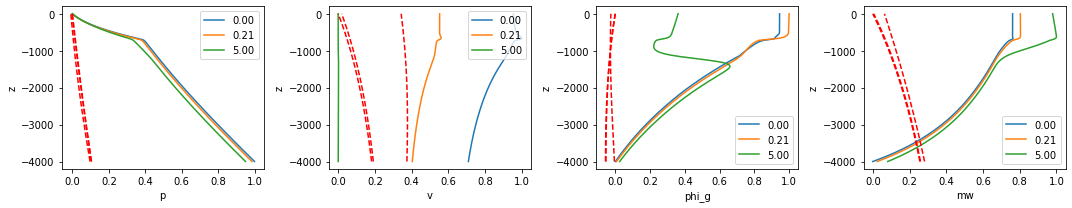

Training:   1%|          | 1000/100000 [00:11<18:33, 88.91it/s]


KeyError: 'mh'

In [20]:
N_ITER=100000
N_DATA_STEPS=1000

conduit_nn = PDENeuralNet(N_INPUTS,N_OUTPUTS) # First output is pressure, second is u

train(conduit_nn, tf.convert_to_tensor(c.in_array), c, conduit_loss)


# How to add the physics

As a reminder, the neural network is set up to mimic the function $f(z,t) = [p, v, \phi_g, m_h](z,t)$, which is a map $\mathbb{R}^2 \to \mathbb{R}^4$.

In practice, we train the neural network with a "batch" of $(z,t)$ samples. This adds an extra dimension to the tensors being passed in and out of the model, where different elements of a batch are stacked along the first axis. Therefore, during training we expect inputs of size $(N,2)$ (2 because of z and t) and outputs of size $(N,4)$ (4 because of the conduit model outputs), where $N$ is the batch size.

## Steady-State Governing Equations

We can write the governing equations for the steady-state conduit model in the form (YQ is working on this)

$$F(z, [\nu, \partial_z \nu]) = 0$$

where $F$ is a matrix of size $(M,1)$ governing equations and $[\nu, \partial_z \nu]$ is a 8-element vector containing the primary conduit variables and their gradients with respect to $z$, e.g. a vector $[p, v, \phi_g, m_h, \partial_z p, \partial_z v, \partial_z \phi_g, \partial_z m_h]$. If we want to write this as a matrix-vector equation, we can express it as 

$$ F(z, [\nu, \partial_z \nu]) = J(z, \nu) \frac{\partial \nu}{\partial z} + Q(z, \nu, \partial_z p) = 0, $$

where $ J(z, \nu)$ is a matrix of size $(M,4)$ containing the coefficients for $\partial_z \nu$ in the $M$ governing equations. However, one issue is that in the  momentum balance equation, $\partial_z p$ appears in the sinh function for the frictional velocity and is therefore not linear in $\partial_z p$, thus  $Q_{mbe}$ does contain the $\partial_z p$ term. 

**Q for Ben**: can we just rewrite the equations in the form $F(z, \nu) = 0$, instead of $J(z, \nu) \frac{\partial \nu}{\partial z} + Q(\nu) = 0$? Since $Q(\nu)$ is so weird and contains $\partial_z p$. Seems like the loss only calculates $F$ anyway. Maybe it would help if you just write down what the loss calculation would be?

Also, how to implement boundary conditions?

**A for YQ**: yes! We can definitely do that. No tensorflow reason to do one or the other -- I just figured you would have written the equations in the $J$, etc. way in your matlab code. I've re-written the loss function to show how that's done.

The tensorflow code will produce conduit variables and their associated derivatives of size (N x 1) (where $N$ is the batch size). From these variables it is easy to assemble the vector $\nu$.

**What we still need:** a function that takes in these variables and gradients, and assembles the matrix $J$. 

Note that because of the batch dimension, $J$ will no longer be of size $(M,12)$, but should be of size $(N,M,12)$. We can then take this tensor and multiply it with $\nu$ to get the governing equations.




## Time-Dependent Governing Equations
The time-dependent governing equations can be rewritten as 

$$H(t, z, [\nu, \partial_z \nu, \partial_t \nu]) = 0, $$

where $H$ is a matrix of size $(M,1)$ governing equations and $[\nu, \partial_z \nu, \partial_t \nu]$ is now a 12-element vector containing the primary conduit variables and their gradients with respect to $z$, e.g. a vector $[p, v, \phi_g, m_h, \partial_z p, \partial_z v, \partial_z \phi_g, \partial_z m_h, \partial_t p, \partial_t v, \partial_t \phi_g, \partial_t m_h]$. We can actually reduce this by one because $ \partial_t v$ does not appear in the governing equations due to low Reynolds number. But wait. Will this result in velocities being constant over time? The assumption here is that $v$ depends on the phase fractions and other properties, not on the inertial term.

If we want to write this as a matrix-vector equation, we can express it as 

$$ H(t, z, [\nu, \partial_z \nu, \partial_t \nu]) =  M(t, z, \nu) \frac{\partial \nu}{\partial t} -  J(t, z, \nu) \frac{\partial \nu}{\partial z} - Q(t, z, \nu, \partial_z p) = 0, $$

### Some numpy manipulations to show how to do the math once we have $J$ and $\nu$

In [46]:
J = np.arange(5*3*4).reshape(5,3,4)
nu = np.arange(5*4).reshape(5,4)
result = np.zeros((5,3))

In [57]:
for i in range(5):
  result[i,:] = J[i,:,:].dot(nu[i,:])
print(result)

[[  14.   38.   62.]
 [ 302.  390.  478.]
 [ 974. 1126. 1278.]
 [2030. 2246. 2462.]
 [3470. 3750. 4030.]]


In [58]:
# Faster (?) alternative
result2 = np.einsum('ijk,ik->ij',J,nu)
print(result2)

[[  14   38   62]
 [ 302  390  478]
 [ 974 1126 1278]
 [2030 2246 2462]
 [3470 3750 4030]]


In [55]:
result == result2

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])